## Import

In [8]:
#################################
# # when running google colab # #
#################################
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install scikeras --quiet

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

NUM_FEATURES = 31
TIMESTEPS = 1
DATASET_LINK = "https://raw.githubusercontent.com/ehandywhyy/ict3204-security-analytics/main/dataset/overall.csv"
TEST_DATA_LINK = "https://raw.githubusercontent.com/ehandywhyy/ict3204-security-analytics/main/dataset/overall_test.csv"

# random seed for reproducibility
SEED = 123

### LOAD DATASET
> * Check for class imbalance

In [10]:
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.142176,0.156880,0.014704,0.127937,0.142299,0.014361,0.155919,...,0.128263,0.085967,-0.042296,0.120442,0.209372,0.088930,0.116911,0.165437,0.048526,0.160258
1,Andy,1,2,0.141793,0.164635,0.022842,0.121625,0.152146,0.030520,0.137039,...,0.144490,0.082397,-0.062093,0.101188,0.126066,0.024878,0.098424,0.130661,0.032238,0.173819
2,Andy,1,3,0.157152,0.147220,-0.009932,0.134796,0.145790,0.010994,0.124892,...,0.135452,0.082423,-0.053029,0.108598,0.155843,0.047244,0.118759,0.146550,0.027791,0.173512
3,Andy,1,4,0.158673,0.142487,-0.016186,0.118908,0.159179,0.040271,0.133175,...,0.114266,0.072556,-0.041711,0.101937,0.145692,0.043755,0.096300,0.122580,0.026280,0.190808
4,Andy,1,5,0.166583,0.157102,-0.009480,0.115094,0.141103,0.026009,0.135121,...,0.125474,0.089247,-0.036227,0.114211,0.149136,0.034925,0.121197,0.230113,0.108917,0.143299


ValueError: Could not interpret input 'Dd.period'

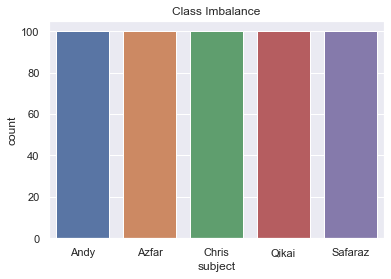

In [53]:
#################################
# # check for class imbalance # #
#################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=df).set_title("Class Imbalance")

# remove missing values if available
df = df.dropna()

sns.catplot(x="subject", y="Dd.period", data=df)

### PREPARING DATASET
> * Split data into X and Y 
> * Convert Y into one-hot-encoding

In [12]:
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to one hot encoded Y for model
Y = Y.reshape(-1, 1)
encoder = OneHotEncoder().fit(Y)
Y = encoder.transform(Y).toarray()

#################################
# # get all the encoded class # #
#################################
print("Encoder is able to decipher: ")
print(encoder.get_feature_names_out())
print("\n")

###########################
# # print X and Y shape # #
###########################
print("X dataset shape: " + str(X.shape))
print("Y dataset shape: " + str(Y.shape))

Encoder is able to decipher: 
['x0_Andy' 'x0_Azfar' 'x0_Chris' 'x0_Qikai' 'x0_Safaraz']


X dataset shape: (500, 31)
Y dataset shape: (500, 5)


### SPLITTING DATASET
> * Split data into train and test dataset 
> * Normalisation performed based on X_train
> * Reshaping of dataset for LSTM Timesteps

In [13]:
# split dataset into train and test of 0.8/0.2 ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)

# normalisation to 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshaping the dataset to include LSTM Timesteps
X_train = np.asarray(X_train, dtype=np.float32)
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

# retrieve number of classes
num_classes = y_train.shape[1]

print("X train shape: " + str(X_train.shape))
print("Y train shape: " + str(y_train.shape))
print("X test shape: " + str(X_test.shape))
print("Y test shape: " + str(y_test.shape))

X train shape: (400, 1, 31)
Y train shape: (400, 5)
X test shape: (100, 1, 31)
Y test shape: (100, 5)


### CREATE MODEL
> * Create base model
> * Wrap it with KerasClassifier

In [14]:
# create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, 
                 input_shape=(TIMESTEPS,NUM_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=100, 
                            batch_size=10)
    return model

### INITIATE KFOLD VALIDATION
> * evaluate best kfold validation
> * generate loss and accuracy graph
> * perform actual kfold validation

##### evaluate suitable kfold validation

In [15]:
# from sklearn.model_selection import LeaveOneOut
# def evaluate_kfold(model, X_train, y_train, SEED):
    
#     # evaluate the model
#     model = create_model()
#     scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
#     ideal, _, _ = mean(scores), scores.min(), scores.max()
#     print('Ideal: %.3f' % ideal)
    
#     folds = range(2,31)
#     means, mins, maxs = list(), list(), list()
    
#     # evaluate each k value
#     for k in folds:
#         # define the test condition
#         kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
#         # evaluate k value
#         model = create_model()
#         scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1)
#         print(scores)
#         k_mean = np.mean(scores)
#         k_min = scores.min()
#         k_max = scores.max()
        
#         # report performance
#         print('> folds=%d, accuracy=%.3f%% (min=%.3f%%, max=%.3f%%)' %
#               (k, k_mean*100, k_min*100, k_max*100))
        
#         # store mean accuracy
#         means.append(k_mean)
        
#         # store min and max relative to the mean
#         mins.append(k_mean - k_min)
#         maxs.append(k_max - k_mean)
        
#     # line plot of k mean values with min/max error bars
#     pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
#     # plot the ideal case in a separate color
#     pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
#     # show the plot
#     pyplot.show()
    
# evaluate_kfold(model, X_train, y_train, SEED)

In [16]:
# ##################################################
# # # evaluate kfold model for accuracy and loss # #
# ##################################################
# def evaluate_kfold_model(X_train, y_train, SEED):
#     scores, histories = list(), list()
#     # create model
#     model = create_model()
#     # prepare cross validation
#     kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)
#     # enumerate splits
#     for train_ix, test_ix in kfold.split(X_train):
#         # select rows for train and test
#         trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
#         # fit model
#         history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_data=(testX, testY), verbose=0)
        
#         # evaluate model
#         y_pred = model.predict(testX)
#         y_pred = to_categorical(y_pred)

#         # evaluate predictions
#         acc = accuracy_score(testY, y_pred)
#         print("Testing accuracy: %.3f%%" % (acc*100))

#         # stores scores and histories
#         scores.append(acc)
#         histories.append(history)

#     for i in range(len(histories)):
#         # plot loss
#         f1 = plt.figure(1)
#         plt.title('Categorical Cross-Entropy Loss')
#         plt.plot(histories[i].history['loss'], color='blue')
#         plt.plot(histories[i].history['val_loss'], color='orange')
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper right')

#         # plot accuracy
#         f2 = plt.figure(2)
#         plt.title('Classification Accuracy')
#         plt.plot(histories[i].history['accuracy'], color='blue')
#         plt.plot(histories[i].history['val_accuracy'], color='orange')
#         plt.ylabel('accuracy')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='lower right')

#     # print summary
#     print('Accuracy: Mean=%.3f Std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
#     # box and whisker plots of results
#     f3 = plt.figure(3)
#     plt.title('Box and Whisker Plot of Accuracy Scores')
#     plt.ylabel('accuracy')
#     plt.xlabel('model')
#     plt.boxplot(scores)
#     plt.show()
    
# evaluate_kfold_model(X_train, y_train, SEED)

##### Perform actual KFold Validation

In [45]:
# create model
model = create_model()

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True,
              random_state=SEED)

valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)

[['Azfar']
 ['Safaraz']
 ['Chris']
 ['Andy']
 ['Andy']
 ['Qikai']
 ['Qikai']
 ['Qikai']
 ['Azfar']
 ['Chris']
 ['Chris']
 ['Safaraz']
 ['Chris']
 ['Azfar']
 ['Andy']
 ['Safaraz']
 ['Azfar']
 ['Safaraz']
 ['Chris']
 ['Azfar']
 ['Azfar']
 ['Chris']
 ['Andy']
 ['Azfar']
 ['Chris']
 ['Safaraz']
 ['Qikai']
 ['Chris']
 ['Safaraz']
 ['Qikai']
 ['Qikai']
 ['Qikai']
 ['Safaraz']
 ['Safaraz']
 ['Andy']
 ['Chris']
 ['Andy']
 ['Safaraz']
 ['Azfar']
 ['Azfar']
 ['Safaraz']
 ['Andy']
 ['Azfar']
 ['Safaraz']
 ['Azfar']
 ['Safaraz']
 ['Andy']
 ['Qikai']
 ['Safaraz']
 ['Safaraz']
 ['Chris']
 ['Andy']
 ['Azfar']
 ['Qikai']
 ['Chris']
 ['Azfar']
 ['Safaraz']
 ['Azfar']
 ['Chris']
 ['Qikai']
 ['Safaraz']
 ['Safaraz']
 ['Chris']
 ['Chris']
 ['Safaraz']
 ['Safaraz']
 ['Andy']
 ['Azfar']
 ['Azfar']
 ['Qikai']
 ['Chris']
 ['Safaraz']
 ['Chris']
 ['Azfar']
 ['Safaraz']
 ['Qikai']
 ['Qikai']
 ['Chris']
 ['Chris']
 ['Chris']
 ['Azfar']
 ['Safaraz']
 ['Chris']
 ['Chris']
 ['Andy']
 ['Qikai']
 ['Azfar']
 ['Safaraz

TypeError: Singleton array array(<built-in method ravel of numpy.ndarray object at 0x000002E24B92CA50>,
      dtype=object) cannot be considered a valid collection.

##### Get Validation Accuracy

In [ ]:
print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))

### MODEL FITTING
> * fit the model
> * view the accuracy and loss graph
> * view model summary

In [12]:
#####################
# # fit the model # #
#####################
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X_train, y_train, callbacks=es)

Epoch 1/100
40/40 [==============================] - 4s 3ms/step - loss: 0.9253 - accuracy: 0.6625
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.4192 - accuracy: 0.8350
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3176 - accuracy: 0.8900
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2819 - accuracy: 0.9050
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3059 - accuracy: 0.8950
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3272 - accuracy: 0.8800
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2276 - accuracy: 0.9125
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2108 - accuracy: 0.9275
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.3311 - accuracy: 0.8800
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2640 - accuracy: 0.9100
Epoch 11/

40/40 [==============================] - 0s 3ms/step - loss: 0.1127 - accuracy: 0.9675
Epoch 84/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1221 - accuracy: 0.9650
Epoch 85/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.9600
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1084 - accuracy: 0.9650
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1485 - accuracy: 0.9525
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0620 - accuracy: 0.9775
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1041 - accuracy: 0.9650
Epoch 90/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 0.9775
Epoch 91/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.9900
Epoch 92/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1332 - accuracy: 0.9625
Epoch 93/100


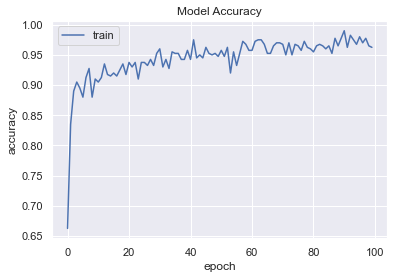

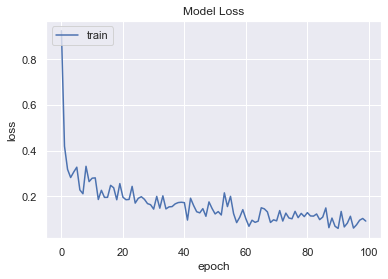

In [13]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
##########################
# # view model summary # #
##########################
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            81920     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 128)           512       
 hNormalization)                                        

### MODEL TESTING
> * get model accuracy on the test dataset
> * save the model if appropriate

In [15]:
y_pred = model.predict(X_test)
y_pred = to_categorical(y_pred)

# evaluate predictions
acc = accuracy_score(y_test, y_pred)
print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 99.000%


In [16]:
##################
# # save model # #
##################

model.model.save("model/key_classifier.h5")

###########################
# # save model in colab # #
###########################

# model.model.save(F"/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LOAD MODEL

In [17]:
##################
# # load model # #
##################

model.model = load_model("model/key_classifier.h5")

###########################
# # load model in colab # #
###########################

# model.model = load_model("/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [18]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.174239,0.409866,0.235627,0.133840,0.171659,0.037820,0.156984,...,0.137544,0.091721,-0.045824,0.099726,0.099142,-0.000585,0.120912,0.135934,0.015022,0.163508
1,Andy,1,2,0.145289,0.154851,0.009562,0.131217,0.129134,-0.002083,0.130980,...,0.164865,0.111584,-0.053281,0.101935,0.023678,-0.078258,0.140863,0.192325,0.051462,0.156958
2,Andy,1,3,0.122266,0.136321,0.014055,0.114905,0.125308,0.010402,0.144332,...,0.145501,0.095982,-0.049520,0.121049,0.091486,-0.029563,0.111422,0.145751,0.034329,0.169304
3,Andy,1,4,0.121075,0.132562,0.011487,0.134813,0.132049,-0.002763,0.135681,...,0.135072,0.089715,-0.045356,0.117885,0.089209,-0.028676,0.098095,0.139069,0.040974,0.168298
4,Andy,1,5,0.141361,0.124721,-0.016640,0.098268,0.149003,0.050735,0.128713,...,0.121480,0.078897,-0.042583,0.108607,0.049435,-0.059172,0.131348,0.156398,0.025050,0.170112


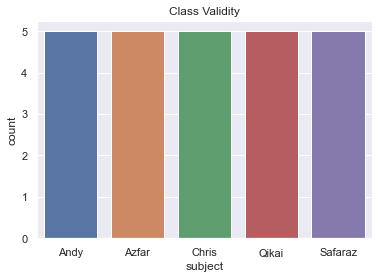

In [19]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
df = df.dropna()

In [20]:
pred_dataset = pred_df.values

# divide data into features X
# X_new = new_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

pred_row=pred_df.iloc[:,3:]

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[0:2,3:]

################################
# # normalise and shape data # #
################################
pred_row = pred_row.values.tolist()
pred_row = scaler.transform(pred_row)
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_row.shape[0], TIMESTEPS, pred_arr.shape[1]))

In [21]:
####################################
# # get prediction and its label # #
####################################

pred = model.predict(pred_arr)
pred = to_categorical(pred)
pred = encoder.inverse_transform(pred)
pred = np.ravel(pred)

pred_proba = model.predict_proba(pred_arr)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

   Prediction  Accuracy
0        Andy  0.999267
1        Andy  0.974872
2        Andy  0.989693
3        Andy  0.959265
4        Andy  0.991036
5       Azfar  0.999673
6       Azfar   0.99978
7       Azfar  0.999537
8       Azfar  0.998587
9       Azfar   0.99973
10      Chris  0.753333
11      Chris  0.998739
12      Chris  0.999506
13      Chris  0.999674
14      Chris  0.998916
15      Qikai  0.999971
16      Qikai  0.999674
17      Qikai  0.965771
18      Qikai  0.999817
19      Qikai  0.993495
20    Safaraz  0.999585
21    Safaraz  0.997843
22    Safaraz  0.996406
23    Safaraz  0.966398
24    Safaraz  0.992766
